In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
!git clone https://github.com/rickiepark/nlp-with-transformers.git
%cd nlp-with-transformers
from install import *
install_requirements(chapter=9)

fatal: destination path 'nlp-with-transformers' already exists and is not an empty directory.
/home/jj/github/NLP/nlp-with-transformers
⏳ Installing base requirements ...
✅ Base requirements installed!
Using transformers v4.31.0
Using datasets v2.10.1
Using nlpaug v1.1.11
Using skmultilearn
Using sacremoses v0.0.41


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

### 많은 양의 레이블링된 데이터가 없을 때 모델 성능을 향상하기 위해 사용하는 방법
레이블링된 데이터가 없음 -> 제로샷 학습  
레이블링된 데이터가 많음 -> 모델 미세 튜닝  
레이블링된 데이터가 적고 레이블링되지 않은 데이터가 없음 -> 임베딩 룩업, 퓨샷 학습  
레이블링된 데이터가 적고 레이블링되지 않은 데이터가 있음 -> 도메인 적응, UDA/UST

이러한 방법 선택 과정을 따라서 지라Jira 또는 깃허브 같은 이슈 트래커issue tracker를 사용하는 많은 고객 지원팀이 마주하는 공통의 문제를 이 장에서 해결해보자.  
-> 바로 이슈 내용을 기반으로 메타데이터metadata의 하나로 태그tag를 추가하는 일이다. (이런 태그는 이슈 종류, 문제를 일으키는 제품, 보고된 이슈를 처리할 팀 등)
### ※ 이 장에서 소개하는 방법은 텍스트 분류에 잘 맞다. 
-> 개체명 인식, 질문 답변, 요약 등 더 복잡한 작업을 해결하려면 데이터 증식 같은 기법이 필요할 수 있다.

# 9.1 깃허브 이슈 태거 만들기

#### 트랜스포머스의 깃허브 이슈를 사용
https://oreil.ly/StdH3  
이 이슈에 어떤 정보가 담겼고 어떻게 이 작업을 구성하고, 어떻게 데이터를 얻는지 알아보기

이슈에 제목, 설명, 이슈의 특징을 나타내는 일련의 태그(=레이블)를 담고있다. -> 지도 학습 작업 가능  
이슈에 여러 개의 레이블을 할당할 수 있으므로 multilabel text classification 문제가 된다.

## 9.1.1 데이터 다운로드 하기

### 이슈 다운로드 코드
-> 직접 이슈를 다운로드하고 싶다면 파이썬에서 HTTP 요청을 처리하는 대표적인 라이브러리인 Requests를 사용해 Issues 엔드포인트를 호출할 수 있다.  
-> 다음은 허깅페이스 트랜스포머스 저장소의 이슈를 다운로드하는 함수다.

In [3]:
# import time
# import math
# import requests
# from pathlib import Path
# import pandas as pd
# from tqdm.auto import tqdm

# def fetch_issues(owner="huggingface", repo="transformers", num_issues=10_000, 
#                  rate_limit=5_000):    
#     batch = []
#     all_issues = []
#     per_page = 100     # 페이지마다 반환되는 이슈 개수
#     num_pages = math.ceil(num_issues / per_page)
#     base_url = "https://api.github.com/repos"
    
#     for page in tqdm(range(num_pages)):
#         # 오픈 이슈와 클로즈 이슈를 모두 가져오기 위해 state=all로 쿼리합니다.
#         query = f"issues?page={page}&per_page={per_page}&state=all"
#         issues = requests.get(f"{base_url}/{owner}/{repo}/{query}")
#         batch.extend(issues.json())

#         if len(batch) > rate_limit and len(all_issues) < num_issues:
#             all_issues.extend(batch)
#             batch = []   # 다음 번 요청을 위해 비웁니다.
#             print(f"깃허브 요청 한도에 도달했습니다. 한 시간 동안 중지합니다...")
#             time.sleep(60 * 60 + 1)
            
#     all_issues.extend(batch)
#     df = pd.DataFrame.from_records(all_issues)
#     df.to_json(f"github-issues-{repo}.jsonl", orient="records", lines=True)

fetch_issues()를 호출할 때 깃허브의 시간 당 요청 횟수 제한을 넘기지 않도록 이슈를 여러 개의 배치로 다운로드합니다.  
이 결과는 github-issues-transformers.jsonl 파일에 저장됩니다. 이 파일의 한 라인은 하나의 이슈를 나타내는 JSON 객체입니다.

#### 데이터를 가져오는 방법
#### -----------------------------------------------------------------------------------
#### 이제부터는 데이터를 정제하는 방법을 살펴보기

## 9.1.2 데이터 준비하기
다운로드한 모든 이슈를 판다스 데이터프레임으로 로드해보자

In [4]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"데이터프레임 크기: {df_issues.shape}")

데이터프레임 크기: (9930, 26)


하나의 행을 출력해보기

In [5]:
a = df_issues.columns
b = []
for x in a:
    b.append(x)

In [6]:
df_issues.loc[2, b].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
repository_url,https://api.github.com/repos/huggingface/trans...
labels_url,https://api.github.com/repos/huggingface/trans...
comments_url,https://api.github.com/repos/huggingface/trans...
events_url,https://api.github.com/repos/huggingface/trans...
html_url,https://github.com/huggingface/transformers/is...
id,849529761
node_id,MDU6SXNzdWU4NDk1Mjk3NjE=
number,11044
title,[DeepSpeed] ZeRO stage 3 integration: getting ...


In [7]:
df_issues.iloc[2:3, :]

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
2,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849529761,MDU6SXNzdWU4NDk1Mjk3NjE=,11044,[DeepSpeed] ZeRO stage 3 integration: getting ...,...,NaN,0,2021-04-02 23:40:42,2021-04-03 00:00:18,NaT,COLLABORATOR,None,"**[This is not yet alive, preparing for the re...",NaN,None


In [8]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
temp = df_issues.loc[2, cols].to_frame()
temp

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


### 이중 주목할 열은 labels다. (각 행마다 레이블에 대한 메타데이터로 구성된 JSON 객체의 리스트가 들어있음)

In [9]:
temp[2]['labels']

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

### 목적상 레이블 객체의 name 필드에만 관심이 있으므로 labels 열을 레이블 이름으로 덮어 쓰기

In [10]:
df_issues["labels"] = (df_issues['labels']
                       .apply(lambda x: [meta["name"] for meta in x]))
df_issues[['labels']].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


이제 labels 열에 있는 각 행은 깃허브 레이블의 리스트가 된다.  
따라서 각 행의 길이를 계산해 이슈에 할당된 레이블의 개수를 구해보자.

In [11]:
df_issues['labels'].apply(lambda x: len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


출력 결과를 보면, 대부분의 이슈는 레이블이 없거나 하나이며, 그 이상 있는 이슈는 적다.  

다음으로 데이터셋에서 가장 많이 등장한 상위 8개의 레이블을 확인해보자  
#### labels 열에 explode() 메서드를 적용하면 리스트에 있는 각 레이블을 열로 변환한다.

In [12]:
df_counts = df_issues["labels"].explode().value_counts()
print(f"레이블 개수: {len(df_counts)}")

레이블 개수: 65


In [13]:
# 상위 8개 레이블을 출력한다.
df_counts.to_frame().head(8).T

labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
count,2284,649,106,98,64,52,50,46


### 분류 작업을 쉽게 만들기 위해 일부 레이블에 대한 태거tagger를 만드는 데 초점을 맞추자.
Good First Issue나 Help Wanted 같은 일부 레이블은 이슈 설명만으로는 예측하기가 매우 어렵다.  
반면 model card 같은 레이블은 허깅페이스 허브에 모델 카드가 추가된 때를 감지하는 간단한 규칙으로 분류할 수 있다.

### 데이터셋을 필터링해 앞으로 다룰 레이블만 남기기. + 읽기 쉽게 변환

In [14]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

In [15]:
df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [16]:
# 이제 새로운 레이블에 대한 분포를 확인해보자.
df_counts = df_issues["labels"].explode().value_counts()

In [17]:
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


### 레이블이 없는 이슈를 별도의 훈련 세트로 다루면 도움된다.  
따라서 이슈에 레이블이 있는지 없는지를 나타내는 열을 새로 만들어보자

In [18]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0

In [19]:
mask

0       False
1       False
2       False
3       False
4       False
        ...  
9925    False
9926    False
9927    False
9928    False
9929    False
Name: labels, Length: 9930, dtype: bool

In [20]:
mask.value_counts()

labels
False    9489
True      441
Name: count, dtype: int64

In [21]:
df_issues.loc[mask, ]

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request,split
26,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,848490060,MDU6SXNzdWU4NDg0OTAwNjA=,11016,Add new CANINE model,...,0,2021-04-01 13:53:21,2021-04-01 14:22:16,NaT,COLLABORATOR,None,# 🌟 New model addition\r\n\r\n## Model descrip...,NaN,None,unlabeled
64,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,848490060,MDU6SXNzdWU4NDg0OTAwNjA=,11016,Add new CANINE model,...,0,2021-04-01 13:53:21,2021-04-01 14:22:16,NaT,COLLABORATOR,None,# 🌟 New model addition\r\n\r\n## Model descrip...,NaN,None,unlabeled
136,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,843129702,MDU6SXNzdWU4NDMxMjk3MDI=,10944,Please implement DUMA: Reading Comprehension w...,...,2,2021-03-29 08:42:13,2021-03-31 03:31:13,NaT,CONTRIBUTOR,None,# 🚀 Feature request\r\n\r\n<!-- A clear and co...,NaN,None,unlabeled
236,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,837364574,MDU6SXNzdWU4MzczNjQ1NzQ=,10844,Add GPT-Neo,...,0,2021-03-22 06:22:48,2021-03-22 06:24:05,NaT,NONE,None,# 🌟 New model addition\r\n\r\nPlease add GPT-N...,NaN,None,unlabeled
293,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,834513340,MDU6SXNzdWU4MzQ1MTMzNDA=,10787,Can DeepSpeed ZeRO-3 be applied for training?,...,3,2021-03-18 08:12:28,2021-03-19 06:59:03,NaT,NONE,None,# 🌟 New model addition\r\n\r\nWe have applied ...,NaN,None,unlabeled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8708,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,542913668,MDU6SXNzdWU1NDI5MTM2Njg=,2345,Feature Request: Pipeline for Query/Document r...,...,3,2019-12-27 15:44:38,2020-05-13 03:17:52,2020-05-13 03:17:52,NONE,None,# Pipelines for IR tasks\r\n\r\n## Justificati...,NaN,None,unlabeled
8760,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,541935686,MDU6SXNzdWU1NDE5MzU2ODY=,2293,Train custom NER model with new Pipeline,...,1,2019-12-23 23:39:26,2020-03-13 14:09:45,2020-03-13 14:09:45,NONE,None,## 🚀 Feature\r\n\r\nNew `Pipelines` feature is...,NaN,None,unlabeled
8806,https://api.github.com/repos/huggingface/trans...,https://api.github.com/re

In [22]:
df_issues.loc[mask, "split"] = "labeled"

In [23]:
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [24]:
# # 위의 과정을 한 셀에 담은 것.

# df_issues["split"] = "unlabeled"
# mask = df_issues["labels"].apply(lambda x: len(x)) > 0
# df_issues.loc[mask, "split"] = "labeled"
# df_issues["split"].value_counts().to_frame()

#### 샘플하나를 확인

In [25]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]} \n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit
tokenization step. While recent tokenization approaches based on data-derived
subword lexicons are less brittle than manually en

labels: ['new model']



이 이슈에서는 새로운 모델 구조를 제안한다. 따라서 new 모델 태그가 적절함.  
title에 담긴 정보가 분류기에 유용하므로 body 필드에 있는 이슈 설명과 합치겠다.

In [26]:
df_issues["text"] = (df_issues.
                     apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

데이터를 더 살펴보기 전, drop_duplicates() 메서드로 중복된 데이터를 삭제

In [27]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"삭제된 중복 이슈ㅣ {(len_before-len(df_issues)) / len_before :.2%}")

삭제된 중복 이슈ㅣ 1.88%


#### 조금 중복된 이슈가 있지만 전체에서 차지하는 양은 적다.  
#### 다른 장처럼 모델의 문맥 크기로 자를 때 너무 많은 정보를 잃지 않는지, 텍스트에 있는 단어 개수를 살펴보아 확인하는 것이 좋다.

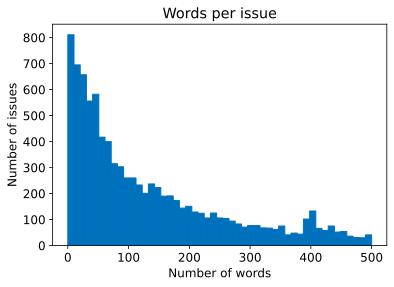

In [28]:
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
    .hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

이 분포에는 많은 텍스트 데이터셋에서 보이는 '롱테일 long tail'특징이 있다.  
대부분의 텍스트가 매우 짧지만, 500단어가 넘는 이슈도 존재.  
특히 에러 메시지나 코드를 함께 포스팅하면 보통 이슈의 길이가 커진다.

대부분의 트랜스포머 모델의 문맥 크기는 512개 토큰이나 그 이상이기 때문에 일부 긴 이슈를 잘라내는 것이 전체 성능에 영향을 미칠 것 같지 않다는게 저자의 의견이다.  

### 데이터셋을 살펴보고 정제했으니, 마지막으로 훈련 세트와 (분류기를 평가할)검증 세트를 정의해보자.

## 9.1.3 훈련 세트 만들기

다중 레이블 문제에서는 모든 레이블에 대해 균형 잡힌 비율을 보장하지 못하기 때문에 train, test set을 만들기가 까다롭다.  
이런 목적을 위해 개발된 scikit-multilearn 라이브러리를 사용하면 도움이 된다. http://scikit.ml  

먼저 'pytorch'와 'tokenization' 같은 레이블을 모델이 처리 가능한 포맷으로 변환한다.  
이를 위해 사이킷런의 MultiLabelBinarizer 클래스를 사용한다. (이 클래스는 레이블 이름의 리스트를 받고 레이블에 해당하는 위치는 1, 나머지는 0인 벡터를 만든다.)

#### 레이블 이름을 ID로 매핑하기 위해 all_labels 리스트에 MultiLabelBinarizer 클래스를 적용해보기

In [29]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [30]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"], ["pytorch", "tokenization"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0]])

In [31]:
mlb.classes_

array(['documentation', 'examples', 'model training', 'new model',
       'pipeline', 'pytorch', 'tensorflow or tf', 'tokenization', 'usage'],
      dtype=object)

#### ※ 벡터의 각 자리가 어떤 클래스에 해당하는지 확인하려면 mlb.classes_ 속성을 참고 (알파벳순)

scikit-multilearn의 iterative_train_test_split() 함수를 사용해 이 데이터셋을 분할한다.  
이 함수는 레이블의 균형을 잡기 위해 반복적으로 훈련/테스트 세트를 만든다.  
이 함수를 DataFrame에 적용하기 위해 별도의 함수로 감싸겠다.  
이 함수는 2차원 특성 행렬을 기대하므로 분할하기 전에 인덱스 배열에 차원을 추가한다.※

※ 아래의 balanced_split() 함수는 interative_train_test_split()에 데이터프레임을 직접 전달하지 않고 인덱스만 전달한다.  
  
이를 위해 열에 해당하는 자원을 추가해 2차원 배열로 만들어야 한다.  
  
그다음 반환된 각 분할의 인덱스를 데이터프레임의iloc 메서드에 전달해 훈련 세트와 테스트 세트를 나눈다.  

또 데이터프레임 df에 레이블 열이 이미 포함됐으므로 iterative_train_test_split()에서 반환된 레이블 분할은 사용하지 않고 버렸다.

In [32]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1) # expand_dims(arr, axis) : 배열의 차원을 확장
    labels = mlb.transform(df["labels"])
    ind_train, y_train, ind_test, y_test = iterative_train_test_split(ind, labels, test_size) # y_train과 y_test는 안씀.(애초에 y가 label 컬럼이기 때문)
    
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

#### 먼저 데이터를 지도 학습 데이터셋과 비지도 학습 데이터셋으로 나눈다.
#### 그다음 balanced_split() 함수를 사용해 지도 학습 데이터셋을 훈련 세트, 검증 세트, 테스트 세트로 균형 있게 나눈다.

In [33]:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy() # drop=True 설정을 안해주면 index 컬럼이 생김
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [34]:
df_clean.head(3)

,text,labels,split
0,Potential incorrect application of layer norm ...,[],unlabeled
1,Multi-GPU seq2seq example evaluation significa...,[],unlabeled
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[],unlabeled


In [35]:
df_unsup.head(3)

,text,labels
0,Potential incorrect application of layer norm ...,[]
1,Multi-GPU seq2seq example evaluation significa...,[]
2,[DeepSpeed] ZeRO stage 3 integration: getting ...,[]


In [36]:
df_sup.head(3)

,text,labels
26,Add new CANINE model\n\n# 🌟 New model addition...,[new model]
107,Please implement DUMA: Reading Comprehension w...,[new model]
207,Add GPT-Neo\n\n# 🌟 New model addition\r\n\r\nP...,[new model]


In [37]:
print(len(df_train))
print(len(df_valid))
print(len(df_test))
print("------")
print(len(df_sup))
print(len(df_unsup))

223
106
111
------
440
9303


### 쉽게 데이터셋을 토큰화하고 Trainer와 통합하기 위해 모든 분할을 담은 DatasetDict 객체를 만들기.  
여기서는 from_pandas() 메서드를 사용해 판다스 DataFrame에서 각 분할을 바로 로드한다.

In [38]:
from datasets import Dataset, DatasetDict

ds = DatasetDict(
    {
        "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
        "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
        "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
        "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))
    }
)

#### 마지막으로 분류기의 성능을 훈련 세트의 크기별로 평가하기 위해 훈련 슬라이스slice를 만들기

## 9.1.4 훈련 슬라이스 만들기
희소하게 레이블링된 데이터와 다중 레이블 분류에 대해서 알아보려 함.  
  
이 장에서 소개하는 각 방법이 적은 양의 레이블링된 데이터에서 얼마나 좋은 성능을 내는지 확인하기 위해  
샘플 개수가 더 적은 훈련 데이터의 슬라이스도 만들어본다.  
  
그다음 샘플 개수에 대한 성능을 그래프로 그려서 여러 방법을 분석한다.  
iterative_train_test_split() 함수를 사용해 레이블마다 여덟 개 샘플로 시작해서 전체 훈련 세트를 담은 슬라이스까지 만들겠다.

In [39]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # 다음 슬라이스 크기를 채우는데 필요한 샘플을 분할한다.
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
                                            indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i == 0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# 마지막 슬라이스를 포함하면 코랩의 경우 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 다음 라인을 주석 처리하세요.
train_slices.append(all_indices), train_samples.append(len(ds["train"]))

train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [40]:
print("목표 분할 크기:")
print(train_samples)
print("실제 분할 크기:")
print([len(x) for x in train_slices])

목표 분할 크기:
[8, 16, 32, 64, 128, 223]
실제 분할 크기:
[10, 19, 36, 68, 134, 223]


주어진 크기에 맞는 균형 잡힌 분할을 구하는 것이 항상 가능하지는 않기 때문에  
이런 반복적인 방식은 원하는 크기에 근사하게만 샘플을 나눈다.

이후 그래프를 그릴 때 목표 분할 크기를 x축으로 사용할 예정이다.

# 9.2 나이브 베이즈 모델 만들기
강력한 기준 모델을 만드는 것은 늘 유익하다.  
  
-> 매우 간단한 모델을 기반으로 하는 기준 모델이 실제로 문제를 잘 해결하기도 하며, 이 경우 배포 및 유지 관리가 힘든 트랜스포머 기반 모델을 쓰는게 더 복잡함  
  
-> 복잡한 모델을 탐색할 때 기준 모델이 간단한 검증 역할을 한다. (복잡한 모델이 80%의 성과를 냈는데 로지스틱 회귀 같은 분류기가 95% 정확도를 달성했다면 모델을 의심하고 디버깅 하는 등)

#### 텍스트 분류의 경우 좋은 기준점은 나이브 베이즈 분류기(Naive Bayes classifier)다.

사이킷런의 나이브 베이즈 구현은 기본적으로 다중 레이블 분류를 지원하지 않지만,  
scikit-multilearn 라이브러리를 사용해 이 문제를 OvR(one-versus-rest) 분류 작업으로 바꾸기.  
(이 방식은 L개의 레이블을 위해 L개의 이진 분류기를 훈련한다.)

#### 먼저 MultiLabelBinarizer 객체를 사용해 새로운 훈련 세트에 label_ids 열을 만들어보자. 
(map() 함수로 모든 처리를 한 번에 수행함)

In [41]:
def prepare_lables(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_lables, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

#### 분류기의 성능을 평가하기 위해 마이크로(micro)와 매크로(macro) f1-score를 사용  
전자는 자주 등장하는 레이블에 대한 성능을 추적,  
후자는 빈도를 무시하고 모든 레이블에 대한 성능을 평균

#### 각 모델을 다른 크기의 훈련 분할에서 평가할 것이므로 defaultdict로 각 분할의 점수를 담을 리스트를 만들겠다.

In [42]:
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [43]:
macro_scores

defaultdict(list, {})

### 모델을 훈련하고 훈련 세트 크기를 증가시키면서 분류기를 평가하기

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터 준비
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩한다.
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련한다.
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가한다.
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
                    y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
                    output_dict=True)
    # 평가 결과를 저장한다.
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

(작업 순서에 대한 설명)  
훈련 슬라이스를 준비하고 레이블을 인코딩한다.  
그다음 CountVectorizer를 사용해 텍스트를 인코딩한다.  
단순하게 어휘사전 크기의 벡터를 만든다.  
이 벡터의 각 원소는 텍스트에 등장한 토큰의 빈도다.  
단어 순서 정보가 모두 없어지기 때문에 이를 BoW(Bag-of-Words) 방식이라 한다.  
그다음 분류기를 훈련하고 테스트 세트에서 예측을 만든 후에 classification_report() 함수를 사용해 마이크로와 매크로 f1-score를 얻는다.

In [45]:
# 실험 결과를 다음 함수를 사용해 그래프로 그리기.  

import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, 
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, 
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

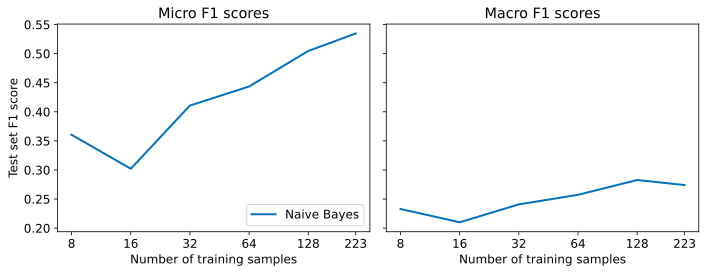

In [46]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

그래프는 샘플 개수를 로그 스케일로 표현함.  
그래프를 보면 훈련 샘플 개수의 증가에 따라 마이크로와 매크로 f1-score가 모두 향상됐다.  
훈련 샘플이 너무 적으면 슬라이스마다 클래스 분포가 달라져 결과에 약간의 잡음이 생긴다.  
하지만 중요한 것은 추세다.  
이런 결과가 트랜스 포머 기반 방식에 어떻게 적용되는지 알아보자

# 9.3 레이블링된 데이터가 없는 경우

(레이블이 있는 과거 데이터가 없거나, 데이터에 대한 레이블을 구하기 어려운 경우 등)  
레이블링된 데이터가 전혀 없는 상황에 적합한 제로샷 분류(zero-shot classification)

제로샷 분류는 작업별 말뭉치에서 추가로 미세 튜닝하지 않고 pretrained 모델을 사용하는 것이 목표

BERT가 수천 권의 책과 위키피디아의 대규모 덤프에서 텍스트에 있는 마스킹된 토큰을 예측하도록 사전 훈련됐다는 사실을 기억할 것.  
누락된 토큰을 잘 ㅖ측하려면 모델은 문맥에 있는 주제를 인식해야 한다.

-> 다음과 같은 문장을 제공해 모델이 문서를 분류하게끔 트릭을 쓸 수 있음. ("This section was about the topic [MASK].")

#### 새로운 영화의 주제가 어떤 것인지 알려주는 함수를 만들려 한다.
자연스럽게 이 작업에 트랜스포머를 사용하게 됐다.  
먼저, masked language model을 사용해 마스킹된 토큰 내용을 예측하는 fill-mask 파이프라인에 BERT 베이스 모델을 로드한다.

In [47]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

그다음 약간의 영화 설명을 작성하고 마스킹된 단어를 위한 프롬프트를 추가한다.  
이 프롬프트는 모델이 분류하도록 안내하는 역할을 한다.  
fill-mask 파이프라인은 마스킹된 위치에 놓기에 가장 가능성이 높은 토큰을 반환한다.

In [48]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 lions:       0.066%
토큰 birds:       0.025%
토큰 love:        0.015%
토큰 hunting:     0.013%


방식을 바꿔 가장 가능성이 높은 토큰을 얻는 대신 주어진 토큰에 대한 확률을 출력하도록 파이프라인을 실행한다.  
  
여기서는 cars와 animals를 선택해 타깃으로 파이프라인에 전달한다.

In [49]:
output = pipe(movie_desc + prompt, targets=["cars", "animals"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 animals:     0.103%
토큰 cars:        0.001%


당연히 cars가 animal보다 확률이 작은게 당연하다. 자동차에 대한 설명에서는 어떤지 확인해보기

In [50]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"토큰 {element['token_str']}:\t{element['score']:.3f}%")

토큰 cars:        0.139%
토큰 animals:     0.006%


지금까지 살펴본 예시는 사전 훈련된 모델을 추가 훈련 없이 다른 작업에 적용하는 방법을 보여준다. (이는 이 장에서 소개할 많은 방법들의 핵심 아이디어다.)  
  
이 예는 분류에 마스크드 언어 모델을 바로 사용하기 위해 마스킹된 프롬프트를 만든다.

### 텍스트 분류에 좀 더 가까운 작업인 자연어 추론 natural language inference(NLI)에서 미세 튜닝된 모델을 적용하면 결과가 더 좋은지 알아보자.

분류할 때 마스크드 언어 모델을 사용하는 것이 좋지만, 좀 더 비슷한 작업에서 훈련된 모델을 사용하는 것이 더 좋을 때도 있다.  
### 바로 텍스트 함의(text entailment)라는 작업이다.

text entailment에서는 모델이 두 개의 텍스트 구절이 서로 연결되는지 아니면 모순되는지 판단한다.  

모델은 일반적으로 MNLI(Multi-Genre NLI) 말뭉치나 XNLI(Cross-Lingual NLI) 말뭉치 같은 데이터셋에서 함의entailment와 모순을 감지하도록 훈련된다.
#### 이 데이터셋에 있는 각 샘플은 전제premise, 가설hypothesis, 레이블 세 부분으로 구성된다.
#### 레이블은 entailment, contradiction, neutral 중 하나다.
entrailment: 전제 조건하에서 가설 텍스트가 참일 때  
contradiction: 전제 조건하에서 가설 텍스트가 거짓이거나 부적합할 때  
neutral: 위의 두 경우에 해당하지 않으면

#### MNLI 데이터셋에서 훈련한 모델을 사용하여 어떤 레이블도 필요하지 않은 분류기를 만들 수 있다.  
-> 핵심 아이디어는 분류하고자 하는 텍스트를 전제로 사용해 다음과 같은 가설을 만드는 것.  
-> "This example is about {label}."

label에는 클래스 이름을 넣는다.  
entailment score는 전제가 주제와 얼마나 관련되는지 알려준다.  
이를 여러 클래스에 순차적으로 실행한다.  
  
이 방식은 클래스마다 정방향 패스를 실행하므로 일반적인 분류기보다 덜 효율적이다.  
또 레이블 이름 선택이 정확도에 큰 영향을 미치므로 이 점을 주의해야 한다.(대체로 의미 있는 이름을 선택하는 것이 좋음)  
예를 들어, 단순히 Class_1 이라고 하면 어떤 의미인지 모델이 알지 못하고 모순인지 함의인지에 대한 힌트를 얻지 못함.

#### 트랜스포머스에는 제로샷 분류를 위한 MNLI 모델이 내장됐다.

In [51]:
from transformers import pipeline

# cpu에서 실행하려면 device=0를 삭제할 것.
pipe = pipeline("zero-shot-classification", device=0)

텍스트를 분류하려면 레이블 이름과 함께 파이프라인에 전달하면 된다.  
또 multi_label=True로 지정하면 단일 레이블 분류를 위한 최댓값이 아니라 모든 점수가 반환된다.  
(단일 레이블 분류의 반환 값은 클래스별 확률의 합이 1이 된다.)  
(다중 레이블 분류에서는 여러 클래스의 확률이 1에 가까워지면 전체 확률의 합이 1을 넘을 수도 있다.)

In [52]:
sample = ds["train"][0]
print(f"레이블: {sample['labels']}")
output = pipe(sample['text'], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\n예측:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

레이블: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o
tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the
title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural
modeling, yet nearly all commonly-used models still require an explicit tokeni

예측:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [53]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [54]:
output

{'sequence': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained inp

### 부분단어 토크나이저를 사용하므로 모델에 코드를 전달할 수도 있다.  
제로샷 파이프라인을 위한 사전 훈련 데이터셋은 코드 비율이 적어서 토큰화가 덜 효율적일 때가 있다.  
하지만 코드도 자연어로 구성되는 부분이 많아 큰 문제가 되지는 않는다.  
또 코드에 프레임워크(파이토치나 텐서플로) 같은 중요한 정보가 담기는 경우도 있다.

### 제로샷 분류의 중요한 부분은 다루고 있는 도메인이다.
여기서 처리하는 텍스트는 매우 기술적이고 대부분 코딩과 관련된 내용이 담기는데, 이는 MNLI 데이터셋에 있는 원래 텍스트 분포와 매우 다르다.  
따라서 당연히 이 작업은 모델에게 어렵다.  
-> 훈련 데이터와 얼마나 비슷한지에 따라 특정 도메인에서 더 잘 수 행되기도 한다.

제로샷 파이프라인에 하나의 샘플을 주입하는 함수를 작성하고  
이를 map() 메서드로 전체 검증 세트에 적용한다.

In [55]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [56]:
ds_zero_shot

Dataset({
    features: ['text', 'labels', 'label_ids', 'predicted_labels', 'scores'],
    num_rows: 106
})

In [57]:
ds_zero_shot[0]

{'text': 'Implementing efficient self attention in T5\n\n# 🌟 New model addition\r\n\r\nMy teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and Nystromformer\r\n\r\n## Model description\r\n\r\nThese new methods serve as approximations of regular attention, but reduce complexity from quadratic in the inputs to linear.  We would like to add a parameter to T5 where users can specify an efficient attention method to use instead of regular attention.  Ideally, this would be implemented across all models, but the models tend to have varying implementations of attention, rendering this generalization fairly tedious.\r\n\r\n## Open source status\r\n\r\n* [x] the model implementation is available: repos are https://github.com/mlpen and https://github.com/lucidrains/performer-pytorch\r\n* [ ] the model weights are available: N/A\r\n* [x] who are the authors: @mlpen and @lucidrains\r\n',
 'labels': ['new model'],
 'label_ids

In [58]:
ds_zero_shot["label_ids"]

[[0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0,

#### 점수를 구했으니, 다음 단계로 샘플마다 어떤 레이블을 할당할지 결정하기.  
선택지는 두 가지다.  
1. threshold를 정의하고 이 threshold를 초과한 모든 레이블을 선택한다.  
2. 점수가 높은 순으로 상위 k개 레이블을 선택한다.  
#### 어떤 방법이 최선인지 판단하기 위해 두 방법 중 하나를 적용해 예측을 추출하는 get_preds() 함수를 만들어보자

In [59]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("`threshold` 또는 `topk`로 지정해야 합니다.")
        
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

#### 그다음 예측 레이블을 사용해 사이킷런의 분류 리포트 결과를 반환하는 두 번째 함수 get_clf_report()를 만든다.

In [60]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
                y_true, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)

#### 이 두 함수로 먼저 k를 증가시키면서 top-k 방법을 적용한다.  
그다음 검증 세트에 대한 마이크로와 매크로 f1-score를 그래프로 그려보자.

In [61]:
macros, micros = [], []
topks = [1,2,3,4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk}) # fn_kwargs는 map으로 적용시킬 함수(여기서는 get_preds)에 전달하는 매개변수
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

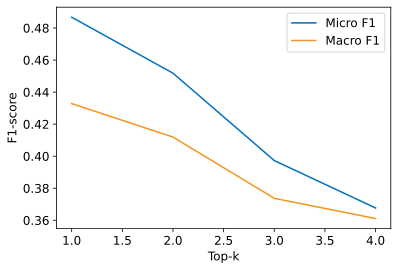

In [62]:
plt.plot(topks, micros, label="Micro F1")
plt.plot(topks, macros, label="Macro F1")
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

탑-1을 선택하는 방식이 최상의 결과를 나타냈다.  
데이터셋의 샘플 대부분에 레이블이 하나 있기 때문에 당연한 결과다.  
#### 샘플당 하나 이상의 레이블을 예측할 수 있으므로 이를 threshold 방식과 비교해보자.

In [63]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

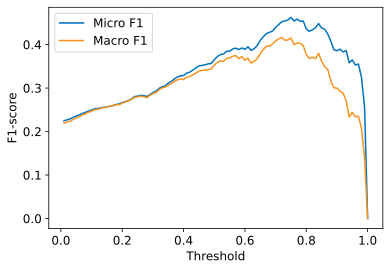

In [64]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

#### 이 방식의 결과는 탑-1 결과보다 다소 나쁘지만, 그래프에 정밀도/재현율의 트레이드 오프가 확실히 나타난다.
임계값을 매우 낮게 설정하면 예측이 매우 많아져 정밀도가 낮아지고,  
임계값을 매우 높게 설정하면 예측하기 어려워져 재현율이 낮아진다.  
이 그래프에서는 0.8 근방의 임계값이 이 둘 사이의 최적 값으로 보인다.

In [65]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f"최상의 임곗값 (마이크로): {best_t}, f1-score {best_micro:.2f}")
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f"최상의 임곗값 (마크로): {best_t}, f1-score {best_macro:.2f}")

최상의 임곗값 (마이크로): 0.75, f1-score 0.46
최상의 임곗값 (마크로): 0.72, f1-score 0.42


### 탑-1 방법이 더 나은 결과를 냈으니 탑-1 방법으로 테스트 세트에서 제로샷 분류와 나이브 베이즈 비교하기

In [66]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Map:   0%|          | 0/111 [00:00<?, ? examples/s]

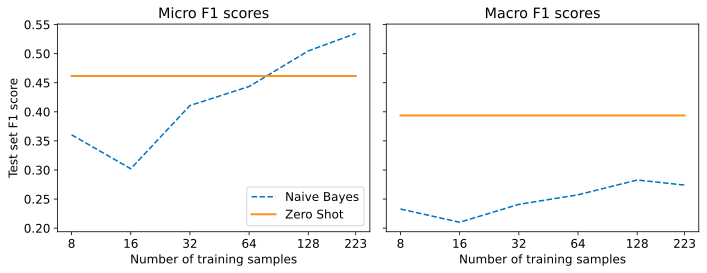

In [67]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

### 제로샷 파이프라인을 기준 모델과 비교하면 두 가지가 관찰된다. 
1. 레이블링된 샘플이 50개보다 더 적다면 제로샷 파이프라인이 기준 모델의 성능을 쉽게 추월한다.  
  
2. 샘플이 50개 이상이더라도 마이크로와 매크로 f1-score를 모두 고려하면 제로샷 파이프라인이 더 낫다.  마이크로 f1-score점수의 결과를 보면, 기준 모델이 빈도가 높은 클래스에서는 잘 동작하지만 제로샷 파이프라인은 학습할 샘플이 필요하지 않기 때문에 기준 모델보다 더 뛰어나다.

### 사실 이 절에는 약간의 모순이 있다. 레이블이 없는 상황인데도 여전히 검증 세트와 테스트 세트를 사용하여 다양한 기술을 소개하고 결과를 비교한다.
#### 실전에서도 간단한 검증을 위해 레이블링된 샘플을 소량 수집하는 편이 좋다.  
#### 이때 데이터를 모델 파라미터를 훈련하는 데 사용하지 않고 하이퍼파라미터를 수정하는 데 사용했다는 점이 중요하다.

### 자신의 데이터셋에서 좋은 결과를 얻기 힘들다면 제로샷 파이프라인의 성능 향상을 위해 몇 가지 방법을 시도해볼 수 있다.
#### 파이프라인의 작동 방식은 레이블 이름에 매우 민감하다. 이름이 무의미하거나 텍스트에 쉽게 연결되지 않으면 파이프라인이 제대로 동작하지 않는다. 따라서 이름을 바꾸거나 여러 이름을 동시에 사용한 다음 후속 단계에서 결과를 집계해보기.
#### 가설을 변형해도 성능이 높아진다. 기본적으로 가설은 hypothesis="This is example is about {}." 이지만 파이프라인에 다른 텍스트를 전달해도 된다. 문제에 따라 성능이 향상하기도 한다.

# 9.4 레이블링된 데이터가 적은 경우
이전 절에서만 하더라도 제로샷 방식이 얼마나 잘 동작하는지 평가하려면 약간의 레이블링된 샘플이 필요하다.  
이 절에서는 소량의 귀중한 레이블링된 데이터를 최대로 활용하는 방법을 알아보자.  
#### 적은 양의 레이블링된 데이터를 몇 배로 늘려주는 데이터 증식 기법부터 알아보자.

## 9.4.1 데이터 증식 data augmentation
-> 기존 샘플에서 새 훈련 샘플을 생성하는 기법  
-> 컴퓨터 비전에서 증강 기법은 일반적이다. (데이터의 의미를 바꾸지 않고 변형 -> 고양이 이미지 회전 등)  
### 텍스트는 단어나 문자가 바뀌면 의미가 완전히 달라지기 때문에 데이터 증식이 조금 더 까다롭다.
예를들어 "Are elephants heavier than mice?" 라는 질문과 "Are mice heavier than elephant?" 라는 질문은 단어의 위치만 바뀌었지만 정반대의 답이 나온다.

하지만 (깃허브 이슈처럼) 텍스트가 여러 문장으로 구성됐다면 이런 변형으로 추가되는 잡음은 대개 레이블에 영향을 미치지 않는다.
### 일반적으로 사용되는 데이터 증식 기법은 두 가지다.
NLP의 데이터 증식 기법에 대한 자세한 목록은 Amit Chaudhary의 블로그 포스트 "A Visual Survey of Data Augmentation in NLP" https://oreil.ly/j6euX 를 참고

1. 역 번역 back translation  
-> 원본 언어로 된 텍스트를 기계 번역을 사용해 하나 이상의 타깃 언어로 번역한다.  
그다음 이를 원본 언어로 다시 번역한다.  
역 번역은 데이터가 많은 언어 또는 도메인 특화된 언어가 매우 많지 않은 말뭉치에서 잘 동작하는 편이다.  

2. 토큰 섞기token perturbations  
-> 훈련 세트의 한 텍스트에서 동의어 교체, 단어 추가, 교환, 삭제 같은 간단한 변환을 임의로 선택해 수행한다.

M2M100 같은 기계 번역 모델을 사용해 역 번역을 구현할 수 있다. https://oreil.ly/gfJCq  
NlpAug와 TextAttack 같은 라이브러리는 다양한 토큰 변환 기법을 제공한다.  
NlpAug https://oreil.ly/UVRci  
TextAttack https://oreil.ly/NMtYi

이 절에서는 구현하기 간단한 동의어 교체에 초점을 두겠다.

#### 동의어 교체를 위해 NlpAug의 ContextualWordEmbsAug 클래스로 DistilBERT의 문맥 단어 임베딩을 사용하겠다.  
간단한 예로 시작하자.

In [68]:
from transformers import set_seed
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

set_seed(3)
text = "Even if you defeat me Megatron, others will rise to defeat your tyranny"
augs = {}
augs["synonym_replace"] = naw.SynonymAug(aug_src='wordnet') # 동의어 교체
augs["random_insert"] = naw.ContextualWordEmbsAug(model_path = "distilbert-base-uncased",
                                                 device="cpu", action="insert", aug_max=1) # 무작위 추가
augs["random_swap"] = naw.RandomWordAug(action="swap") # 무작위 교체
augs["random_delete"] = naw.RandomWordAug()
augs["bt_en_de"] = naw.BackTranslationAug(
                        from_model_name='facebook/wmt19-en-de',
                        to_model_name='facebook/wmt19-de-en') # 역 번역 (독일어)
for k, v in augs.items():
    print(f"원본 텍스트: {text}")
    print(f"{k}: {v.augment(text)}")
    print("")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jj/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jj/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
synonym_replace: ['Even if you vote down me Megatron, others will turn out to
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_insert: ['even if you defeat me megatron, others will rise to violently
defeat your tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_swap: ['Even if you defeat Megatron me, others to will rise defeat your
tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
random_delete: ['Even if me Megatron, will rise to tyranny']

원본 텍스트: Even if you defeat me Megatron, others will rise to defeat your tyranny
bt_en_de: ['Even if you defeat me, others will rise up to defeat your tyranny']



In [69]:
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", 
                                device="cpu", action="substitute")

text = "Transformers are the most popular toys"
print(f"원본 텍스트: {text}")
print(f"대체된 텍스트: {aug.augment(text)}")

원본 텍스트: Transformers are the most popular toys
대체된 텍스트: ['transformers — the most coveted toys']


### 위의 증식 코드를 간단한 함수로 감싸기

In [70]:
# transformations_per_example = n (n개의 새로운 훈련 샘플을 생성)
# 이 경우 배치 속에 포함된 여러 데이터들이 자기차례마다 1개의 새로운 샘플 데이터를 생성.
# text_aug에는 ["원본텍스트1", "생성텍스트1", "원본텍스트2", "생성텍스트2", ... 배치수만큼]
# labels_ids의 경우, 생성한텍스트의 정답 라벨은 원본과 같으므로 똑같이 정답이 적힌 labels를 한 번 더 넣어 원본1,생성1과 같은 정답라벨 인덱스를 맞춰준다

def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch['text'], batch['label_ids']):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
            
    return {"text": text_aug, "label_ids": label_ids}    

#### 이 함수를 map() 메서드에 전달할 때 transformations_per_example 매개변수에 새로 생성할 샘플 수를 지정할 수 있다. 
이 함수를 사용하면 훈련 슬라이스를 선택한 후 코드 한 줄만 추가하여 나이브 베이즈 분류기를 훈련할 수 있다.

In [71]:
ds_train_sample.column_names

['text', 'labels', 'label_ids']

In [72]:
ds_train_sample[0]

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

In [73]:
for train_slice in train_slices:
    # 훈련 슬라이스와 테스트 데이터를 준비한다.
    ds_train_sample = ds["train"].select(train_slice)
    # 증식 결과를 펼쳐서 레이블에 정렬한다.
    ds_train_aug = (ds_train_sample
                    .map(augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # 간단한 CountVectorizer를 사용해 텍스트를 토큰 카운트로 인코딩한다.
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # 모델을 만들고 훈련한다.
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # 예측을 생성하고 평가한다.
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
                    y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
                    output_dict=True)
    # 평가 결과를 저장한다.
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

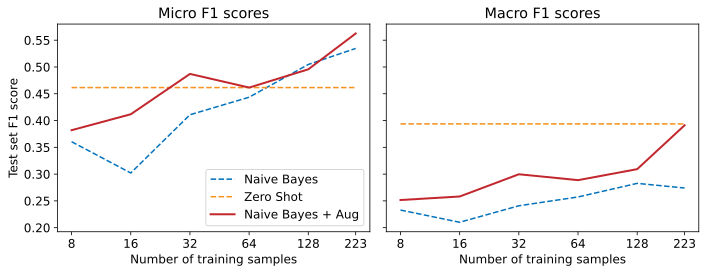

In [74]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

소량의 데이터 증식으로 나이브 베이즈 분류기의 f1-score가 약 5포인트 상승했다.  
약 170개 훈련 샘플을 사용하면 매크로 점수에서 제로샷 파이프라인의 성능을 추월한다.  

이제 대규모 언어 모델의 임베딩을 사용하는 방법을 알아보자.

## 9.4.2 임베딩을 룩업 테이블로 사용하기
이 절에서는 OpenAI API 분류 엔드포인트를 본떠 텍스트 분류기를 만들겠다.  
1. 언어 모델을 사용해 레이블링된 전체 텍스트를 임베딩한다.  
2. 저장된 임베딩에 최근접 이웃 검색을 수행한다.  
3. 최근접 이웃의 레이블을 수집해 예측을 만든다.

이 방식은 레이블링된 데이터 포인트를 활용하기 위해 모델을 미세튜닝할 필요가 없다.  
다만 현재 데이터셋과 비슷한 도메인에서 사전 훈련시킨 적절한 모델을 선정할 필요가 있다.

여기서는 GPT-2의 변종 모델을 사용하여 깃허브 이슈에 담긴 일부 문맥을 감지할 것.

### 텍스트 리스트를 받고 이 모델을 사용해 각 텍스트에 대해 하나의 벡터 표현을 만드는 헬퍼 함수를 만들어보자.
-> 그런데 한 가지 문제가 있음. GPT-2 같은 트랜스포머 모델은 토큰마다 하나의 임베딩 벡터를 반환한다.  
-> 'I took my dog for a walk'라는 문장이 주어지면 하나의 문장에서 토큰마다의 임베딩 벡터 여러 개가 반환되지만 실제로 필요한 것은 전체 문장에 대한 임베딩 벡터 하나다.  
  
-> 이를 처리하기 위해 풀링pooling 기법 사용.  
-> 가장 간단한 방법은 토큰 임베딩을 평균하는 평균 풀링 mean pooling이다.  
-> 평균 풀링에서 주의할 점은 평균에 '패딩 토큰'을 포함하지 말아야 한다는 점이다. (어텐션 마스크를 사용해 이를 처리)

In [75]:
import torch
from transformers import AutoTokenizer, AutoModel

# 코랩에서 python-gpt2-large를 사용하면 메모리 부족이 발생합니다.
# 대신 코랩 프로(https://colab.research.google.com/signup)를 사용하세요.
# 코랩을 사용하려면 대신 python-gpt2-medium을 사용하세요.
model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # 토큰 임베딩 추출하기
    token_embeddings = model_output[0]
    # 어텐션 마스크 계산하기
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float())
    # 임베딩을 더하지만 마스킹된 토큰은 무시한다.
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) # sum(1)은 각 행마다 모든 열을 더한 값. 즉 열벡터가 나올 것임
    # 하나의 벡터로 평균을 반환한다.
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       max_length=128, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

이제 각 분할에 대한 임베딩을 얻을 수 있다.  
GPT 스타일의 모델은 패딩 토큰이 없으므로 앞의 코드에서 구현된 것처럼 배치 형식으로 임베딩을 구하려면 패딩 토큰을 추가해야 한다.  
이를 위해서 EOS(end-of-string) 토큰을 재사용하겠다.

In [76]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

모든 임베딩이 준비됐으니 이를 검색할 시스템을 구성한다.  
#### 쿼리할 새로운 텍스트 임베딩과 훈련 세트에 있는 기존 임베딩 사이의 코사인 유사도 cosine similarity를 계산하는 함수를 작성한다.
#### 또는 FAISS 인덱스라 부르는 데이터셋의 내장 구조를 사용한다.
FAISS: 유사한 벡터를 검색해서 가져오는 facebook의 라이브러리  
이를 임베딩을 위한 검색 엔진으로 생각할 수 있다.  

add_faiss_index()를 사용하면 데이터셋의 기존 필드를 FAISS 인덱스로 만든다.  
또 add_faiss_index_from_external_arrays()를 사용하면 새로운 임베딩을 데이터셋으로 로드한다.

### 전자의 방법을 사용해 다음처럼 훈련 임베딩을 데이터 셋에 추가한다.
(FAISS를 사용하려면 conda나 pip로 faiss-cpu 또는 faiss-gpu 패키지를 설치해야 한다.)

In [77]:
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

embedding이라는 새로운 FAISS 인덱스를 만들었다.  
이제 get_nearest_examples() 메서드를 호출해 최근접 이웃 룩업을 수행한다. -> 이 메서드는 가장 가까운 이웃과 각 이웃의 매칭 점수를 반환한다.  
이를 위해 쿼리 임베딩과 추출할 최근접 이웃 개수를 지정한다.

이 메서드를 호출해서 주어진 샘플과 가장 가까운 문서를 확인해보자

In [78]:
i, k = 0, 3    # 첫 번째 쿼리와 3개의 최근접 이웃을 선택한다.
rn, nl = "\r\n\r\n", "\n" # 간결한 출력을 위해 텍스트에서 줄바꿈 문자를 삭제함.

query = np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", query, k=k) # k개의 최근접 이웃 선택

print(f"쿼리 레이블: {embs_valid[i]['labels']}")
print(f"쿼리 텍스트: {embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"추출된 문서:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"텍스트:\n{text[:200].replace(rn, nl)} [...]")
    print(f"점수: {score:.2f}")
    print(f"레이블: {label}")

쿼리 레이블: ['new model']
쿼리 텍스트: Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self
attention methods such as Linformer, Performer and [...]

추출된 문서:
텍스트:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
점수: 54.92
레이블: ['new model']
텍스트:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to
Transformers library?
## Model description
The n [...]
점수: 57.90
레이블: ['new model']
텍스트:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based
models with sign [...]
점수: 60.12
레이블: ['new model']


#### 임베딩 룩업으로 얻은 세 문서는 레이블이 모두 똑같다.
제목을 보면 세 문서가 매우 비슷하고, 쿼리와 검색된 문서는 고효율의 신형 트랜스포머 모델을 추가하는 문제를 다룬다.

### 하지만 최적의 k값은 얼마일까?
  
이를 체계적으로 조사하기 위해 헬퍼 함수를 만들어 몇 개의 k 값과 레이블 할당을 위한 임곗값 m < k를 바꾸자.  
  
각 설정에서 매크로와 마이크로 f1-score를 기록해 나중에 가장 좋은 성능을 내는 설정을 정한다.  
검증 세트에 있는 각 샘플에서 루프를 반복하지 않고 쿼리 배치를 받는 get_nearest_examples_batch() 메서드를 사용한다.

In [79]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

In [80]:
def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k) # 들어온 데이터셋의 데이터 수가 17개 이하일 수 있으니까
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k+1):
            _, samples = ds_train.get_nearest_examples_batch("embedding",
                                                             valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                                                  target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

### 모든 k와 m 설정에서 전체 훈련 샘플을 사용해 최상의 값을 찾고 이 점수를 시각화

In [81]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

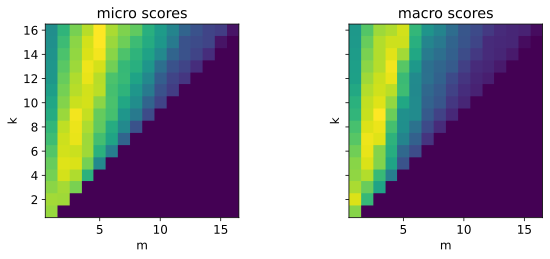

In [82]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
ax1.set_ylabel("k")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17-0.5])
    ax.set_ylim([0.5, 17-0.5])
    # ax.set_ylim([17-0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

그래프에서 패턴을 찾을 수 있다.  
어떤 k에서 m이 너무 크거나 작으면 최적이 아닌 결과를 얻음

In [83]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape) # np.unravel_index는 전달한 값이 함께 전달한 매트릭스의 크기에서 몇 번째 좌표에 존재할지 위치를 알려주는 함수
print(f"최상의 k: {k}, 최상의 m: {m}")

최상의 k: 15, 최상의 m: 5


#### 15개의 최근접 이웃을 검색하고 최소한 5회 등장한 레이블을 할당할 때 최상의 성능을 달성한다.

임베딩 룩업을 위해 최상의 값을 찾는 좋은 방법을 알았으니, 나이브 베이즈 분류기처럼 훈련 세트 슬라이스를 사용해 성능을 평가해보자.

데이터셋을 슬라이싱하기 전에 FAISS 인덱스는 데이터셋처럼 슬라이싱하지 못하므로(전체 데이터를 고려해서 만들어 졌기 때문) 인덱스를 삭제한다.  
나머지 루프는 최상의 k와 m 값을 구하기 위해 검증 세트를 사용하는 것 외에는 이전과 같다.

In [84]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # 훈련 슬라이스로부터 FAISS 인덱스를 만든다.
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")
    # 검증 세트로 최상의 k, m 값을 구한다.
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # 테스트 세트에서 예측을 만든다.
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # 예측을 평가합니다.
    clf_report = classification_report(test_labels, y_pred,
                                       target_names=mlb.classes_, zero_division=0, output_dict=True)
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

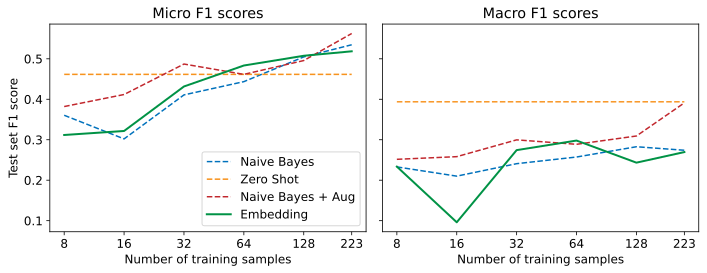

In [85]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

#### 결과를 저장한다.

In [86]:
import joblib

joblib.dump({'micro': micro_scores, 'macro': macro_scores}, '09_results_of_faiss.gz')

['09_results_of_faiss.gz']

## FAISS
프로젝트에 FAISS를 사용하고 싶다면 적절한 방식을 선택하기 위해 FAISS 저장소에 수록된 간단한 가이드를 참고.  
https://oreil.ly/QmvzR  

쿼리 벡터와 가장 가깝거나 비슷한 문서의 벡터 항목들을 찾아냄

### CCMatrix 말뭉치
다국어 임베딩을 사용해 다른 언어에서 동일한 문장을 찾음.  
이 거대한 말뭉치는 100개 언어를 직접 번역하는 대규모 기계 번역 모델인 M2M100을 훈련하는 데 사용됐다.

## 9.4.3 기본 트랜스포머 미세 튜닝하기

레이블링된 데이터가 있다면 사전 훈련된 트랜스포머 모델의 미세 튜닝도 가능하다.  
먼저 사전 훈련 토크나이저를 로드해 데이터셋을 토큰화한 다음, 훈련과 평가에 필요 없는 열을 삭제해보기

In [87]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased" # uncased는 대소문자를 무시. 모든 문자를 소문자로 변환하여 처리
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128) # truncation=True : 입력 텍스트의 길이가 max_length보다 길 경우 잘라내도록 설정
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

### 다중 레이블 손실 함수는 이산적인 레이블 대신 클래스 확률도 사용할 수 있기 때문에 실수 타입의 레이블을 기대한다.

따라서 label_ids 열의 타입을 실수로 바꿔야 한다.

#### 열 원소의 포맷을 바꾸면 애로우의 타입 포맷(typed format)에서 잘 동작하지 않으므로 조금 돌아가야 한다.  
먼저 레이블로 새 열을 만든다. (이 열의 포맷은 첫 번째 원소로 추론한다.)  
그다음 원본 열을 삭제하고 새 열의 이름을 바꿔 원본 열을 대체한다.

※ 애로우(Arrow)는 대규모 데이터 처리를 위한 고성능 열 지향(in-memory columnar) 데이터 프레임워크입니다.

In [88]:
ds_enc

DatasetDict({
    train: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 106
    })
    test: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9303
    })
})

In [89]:
ds_enc['train'][0]

{'label_ids': [0, 0, 0, 1, 0, 0, 0, 0, 0],
 'input_ids': [101,
  5587,
  2047,
  28735,
  2944,
  1001,
  100,
  2047,
  2944,
  2804,
  1001,
  1001,
  2944,
  6412,
  8224,
  3728,
  3818,
  1037,
  2047,
  1008,
  1008,
  1039,
  1008,
  1008,
  18820,
  21162,
  1008,
  1008,
  1037,
  1008,
  1008,
  22110,
  16584,
  22471,
  5397,
  2007,
  1008,
  1008,
  1050,
  1008,
  1008,
  1051,
  19204,
  3989,
  1008,
  1008,
  1045,
  1008,
  1008,
  1050,
  1008,
  1008,
  1050,
  1008,
  1008,
  7327,
  7941,
  1008,
  1008,
  1041,
  1008,
  1008,
  13316,
  27381,
  2015,
  4294,
  1006,
  28735,
  1007,
  1012,
  2025,
  2069,
  1996,
  2516,
  2003,
  10990,
  1024,
  1028,
  13117,
  2094,
  17953,
  2361,
  3001,
  2031,
  4321,
  2042,
  19886,
  2011,
  2203,
  1011,
  2000,
  1011,
  2203,
  15756,
  11643,
  1010,
  2664,
  3053,
  2035,
  4141,
  1011,
  2109,
  4275,
  2145,
  5478,
  2019,
  13216,
  19204,
  3989,
  3357,
  1012,
  2096,
  3522,
  19204,
  3989,
  8107,

In [90]:
ds_enc.set_format("torch")
ds_enc

DatasetDict({
    train: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 106
    })
    test: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['label_ids', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9303
    })
})

In [91]:
ds_enc['train'][0]

{'label_ids': tensor([0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'input_ids': tensor([  101,  5587,  2047, 28735,  2944,  1001,   100,  2047,  2944,  2804,
          1001,  1001,  2944,  6412,  8224,  3728,  3818,  1037,  2047,  1008,
          1008,  1039,  1008,  1008, 18820, 21162,  1008,  1008,  1037,  1008,
          1008, 22110, 16584, 22471,  5397,  2007,  1008,  1008,  1050,  1008,
          1008,  1051, 19204,  3989,  1008,  1008,  1045,  1008,  1008,  1050,
          1008,  1008,  1050,  1008,  1008,  7327,  7941,  1008,  1008,  1041,
          1008,  1008, 13316, 27381,  2015,  4294,  1006, 28735,  1007,  1012,
          2025,  2069,  1996,  2516,  2003, 10990,  1024,  1028, 13117,  2094,
         17953,  2361,  3001,  2031,  4321,  2042, 19886,  2011,  2203,  1011,
          2000,  1011,  2203, 15756, 11643,  1010,  2664,  3053,  2035,  4141,
          1011,  2109,  4275,  2145,  5478,  2019, 13216, 19204,  3989,  3357,
          1012,  2096,  3522, 19204,  3989,  8107,  2241,  2006,  2

In [92]:
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)},
                    remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [93]:
ds_enc['train'][0]

{'input_ids': tensor([  101,  5587,  2047, 28735,  2944,  1001,   100,  2047,  2944,  2804,
          1001,  1001,  2944,  6412,  8224,  3728,  3818,  1037,  2047,  1008,
          1008,  1039,  1008,  1008, 18820, 21162,  1008,  1008,  1037,  1008,
          1008, 22110, 16584, 22471,  5397,  2007,  1008,  1008,  1050,  1008,
          1008,  1051, 19204,  3989,  1008,  1008,  1045,  1008,  1008,  1050,
          1008,  1008,  1050,  1008,  1008,  7327,  7941,  1008,  1008,  1041,
          1008,  1008, 13316, 27381,  2015,  4294,  1006, 28735,  1007,  1012,
          2025,  2069,  1996,  2516,  2003, 10990,  1024,  1028, 13117,  2094,
         17953,  2361,  3001,  2031,  4321,  2042, 19886,  2011,  2203,  1011,
          2000,  1011,  2203, 15756, 11643,  1010,  2664,  3053,  2035,  4141,
          1011,  2109,  4275,  2145,  5478,  2019, 13216, 19204,  3989,  3357,
          1012,  2096,  3522, 19204,  3989,  8107,  2241,  2006,  2951,  1011,
          5173,  4942, 18351, 16105,  8

#### 크기가 작기 떄문에 훈련 데이터에 금세 over fitting 될 가능성이 높다.  
따라서 load_best_model_at_end = True로 설정해서 마이크로 F1-score를 기반으로 최선의 모델을 선택한다.

※ load_best_model_at_end = True (학습이 종료된 후 가장 좋은 모델을 로드)

In [94]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0, 
    evaluation_strategy="epoch", save_strategy="epoch",logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model='micro f1',
    save_total_limit=1, log_level='error')

#### 최상의 모델을 선택하려면 f1-score가 필요하다. (따라서 평가 단계에서 이를 계산함)  

#### 모델이 로짓을 반환하므로 먼저 시그모이드 함수로 예측을 정규화하고, 그다음 간단한 임곗값으로 이를 이진화한다.  
그 후 분류 리포트를 사용해 관심 대상 점수를 반환한다.

In [95]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)
    
    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

### 이제 훈련할 준비가 됐으니 훈련 세트 슬라이스마다 처음부터 분류기를 훈련하고, 훈련 루프 끝에서 최상의 모델을 로드하고, 테스트 세트의 결과를 저장한다.

In [96]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [97]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.679, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6283273696899414, 'eval_micro f1': 0.21256038647342992, 'eval_macro f1': 0.10017373764742185, 'eval_runtime': 0.5204, 'eval_samples_per_second': 203.677, 'eval_steps_per_second': 7.686, 'epoch': 1.0}
{'loss': 0.5914, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5823866128921509, 'eval_micro f1': 0.22910216718266255, 'eval_macro f1': 0.09228538883711297, 'eval_runtime': 0.5246, 'eval_samples_per_second': 202.056, 'eval_steps_per_second': 7.625, 'epoch': 2.0}
{'loss': 0.5591, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.5439628958702087, 'eval_micro f1': 0.06211180124223603, 'eval_macro f1': 0.050462962962962966, 'eval_runtime': 0.5301, 'eval_samples_per_second': 199.971, 'eval_steps_per_second': 7.546, 'epoch': 3.0}
{'loss': 0.522, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.503508448600769, 'eval_micro f1': 0.016129032258064516, 'eval_macro f1': 0.017094017094017096, 'eval_runtime': 0.5216

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5874, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.536561131477356, 'eval_micro f1': 0.01652892561983471, 'eval_macro f1': 0.013071895424836602, 'eval_runtime': 0.5305, 'eval_samples_per_second': 199.798, 'eval_steps_per_second': 7.54, 'epoch': 1.0}
{'loss': 0.4908, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4717029929161072, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5295, 'eval_samples_per_second': 200.188, 'eval_steps_per_second': 7.554, 'epoch': 2.0}
{'loss': 0.4297, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.435634583234787, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5229, 'eval_samples_per_second': 202.712, 'eval_steps_per_second': 7.65, 'epoch': 3.0}
{'loss': 0.3952, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.411484956741333, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5287, 'eval_samples_per_second': 200.499, 'eval_steps_per_second': 7.566, 'epoch': 4.0}
{'loss': 0.3771,

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5649, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5039723515510559, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5354, 'eval_samples_per_second': 197.978, 'eval_steps_per_second': 7.471, 'epoch': 1.0}
{'loss': 0.4552, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4264884889125824, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5336, 'eval_samples_per_second': 198.641, 'eval_steps_per_second': 7.496, 'epoch': 2.0}
{'loss': 0.3921, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3901907801628113, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5318, 'eval_samples_per_second': 199.309, 'eval_steps_per_second': 7.521, 'epoch': 3.0}
{'loss': 0.3554, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.36696499586105347, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5403, 'eval_samples_per_second': 196.202, 'eval_steps_per_second': 7.404, 'epoch': 4.0}
{'loss': 0.3332, 'learning_rate': 3e-05, 'e

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5084, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.425136923789978, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5362, 'eval_samples_per_second': 197.7, 'eval_steps_per_second': 7.46, 'epoch': 1.0}
{'loss': 0.3871, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3699575364589691, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5454, 'eval_samples_per_second': 194.362, 'eval_steps_per_second': 7.334, 'epoch': 2.0}
{'loss': 0.3477, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3581755757331848, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5385, 'eval_samples_per_second': 196.85, 'eval_steps_per_second': 7.428, 'epoch': 3.0}
{'loss': 0.512, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.48628026247024536, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5512, 'eval_samples_per_second': 192.323, 'eval_steps_per_second': 7.257, 'epoch': 4.0}
{'loss': 0.4027, 'learning_rate': 3e-05, 'epoch':

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4631, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.38703542947769165, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.536, 'eval_samples_per_second': 197.77, 'eval_steps_per_second': 7.463, 'epoch': 1.0}
{'loss': 0.3662, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3655720055103302, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5368, 'eval_samples_per_second': 197.458, 'eval_steps_per_second': 7.451, 'epoch': 2.0}
{'loss': 0.354, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.36154404282569885, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5353, 'eval_samples_per_second': 198.018, 'eval_steps_per_second': 7.472, 'epoch': 3.0}
{'loss': 0.351, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.36033645272254944, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5326, 'eval_samples_per_second': 199.041, 'eval_steps_per_second': 7.511, 'epoch': 4.0}
{'loss': 0.3519, 'learning_rate': 3e-05, 'epo

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4165, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.3551226258277893, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5364, 'eval_samples_per_second': 197.628, 'eval_steps_per_second': 7.458, 'epoch': 1.0}
{'loss': 0.3307, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3106682598590851, 'eval_micro f1': 0.24817518248175183, 'eval_macro f1': 0.10409356725146197, 'eval_runtime': 0.5376, 'eval_samples_per_second': 197.155, 'eval_steps_per_second': 7.44, 'epoch': 2.0}
{'loss': 0.2786, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.26691681146621704, 'eval_micro f1': 0.49101796407185627, 'eval_macro f1': 0.1861111111111111, 'eval_runtime': 0.5417, 'eval_samples_per_second': 195.674, 'eval_steps_per_second': 7.384, 'epoch': 3.0}
{'loss': 0.2374, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.2551038861274719, 'eval_micro f1': 0.45238095238095233, 'eval_macro f1': 0.2108058608058608, 'eval_runtime': 0.5376, 'eval_samples_per_second': 197.1

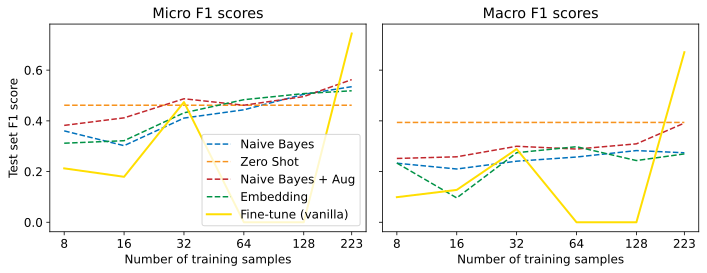

In [98]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

## 9.4.4 프롬프트를 사용한 인-컨텍스트 학습과 퓨샷 학습

이 장의 앞부분에서 BERT나 GPT-2 같은 언어 모델을 사용해 지도 학습에 적용했다.  
이를 위해 프롬프트를 사용하고 모델의 토큰 예측을 파싱한다.  
이 방식은 작업에 특화된 헤드를 추가하고 모델 파라미터를 작업에 맞게 튜닝하는 전통적인 방식과 다르다.  
#### 훈련 데이터가 전혀 필요하지 않은 장점과 가지고 있는 레이블링된 데이터를 활용할 수 없는 단점이 있다.

#### 그 절충안으로 인-컨텍스트 학습 in-context learning 또는 퓨샷 학습few-shot learning을 활용하는 방법도 있다.  
개념을 설명하기 위해 영어를 프랑스어로 번역하는 작업을 생각해보자.  
제로샷 패러다임에서 다음과 같은 프롬프트를 만든다.

In [99]:
prompt = """\
Translate English to French:
thanks =>
"""

이 프롬프트는 모델이 단어 'merci'를 예측하도록 유도한다.  
6장에서 요약을 위해 GPT-2를 사용할 때 텍스트에 'TL;DR'을 추가해서 모델이 텍스트로 명시적 훈련을 받지 않고도 요약을 생성하도록 유도했다.  
GPT-3 논문에서 흥미로운 점은 프롬프트가 있는 샘플에서 효과적으로 학습하는 대규모 언어 모델의 능력이다. 따라서 앞의 번역 샘플에 영어-프랑스어 번역 샘플 몇 개를 보강하면 모델이 작업에서 더 뛰어난 성능을 낸다.

### 게다가 저자들은 모델이 클수록 인-컨텍스트 샘플을 더 잘 사용해 성능이 크게 향상됨을 알았다.

-> GPT-3 정도 크기의 모델을 실전 제품에 사용하기가 어렵지만, 자연어로 명령을 입력하고 GPT-3가 파싱해 명령을 셸에 전달하는 자연어 셀shell 같은 멋진 어플도 존재

#### 레이블링된 데이터를 사용하는 또 다른 방법으로 프롬프트 샘플과 원하는 예측을 만들고 이런 샘플로 언어 모델을 계속 훈련하는 방법이 있다.
이 방식을 따르는 ADAPET이란 이름의 새 방법은 생성된 프롬프트로 모델을 튜닝해 다양한 작업에서 GPT-3를 능가하는 성능을 보여준다.

이 방식은 사용자 헤드를 미세 튜닝하는 것보다 더 데이터 효율적일 수도 있다.

#### 이 절에서는 몇 개의 레이블링된 샘플을 잘 활용하는 다양한 방법을 간략하게 알아봤다.
#### 이제 더 흔한 경우인 레이블링된 샘플 외에 레이블링 되지 않은 데이터가 더 많은 경우 이를 잘 활용하는 방법에 대해서 알아보자.

# 9.5 레이블링되지 않은 데이터 활용하기

사전 훈련 작업이 후속 작업의 목표에 가깝다면(사전 훈련 텍스트와 후속 작업 텍스트의 구조가 비슷하다던가) 전이 학습의 성능이 높아진다.

밑바닥부터 재훈련하는 방법과 분류를 위해 그냥 모델을 사용하는 방법의 절충점 -> 도메인 적응(domain adaption)이라 한다. (7장의 QA에서도 봄)  
  
도메인 적응(DA) : 언어 모델을 밑바닥부터 재훈련하는 대신 주어진 도메인의 데이터에서 계속 훈련하는 방법이다.  
이 단계에서는 마스킹된 단어를 예측하는 고전적인 언어 모델의 목표를 사용한다. -> 즉 레이블링된 데이터가 필요하지 않다.  
그다음 적응된 모델을 분류기로 로드하고 미세 튜닝해서 레이블링되지 않은 데이터를 활용한다.

### 도메인 적응은 레이블링된 데이터에 비해 레이블링되지 않은 데이터가 풍부한 경우가 많다는 사실을 활용한다.
게다가 적응된 모델은 많은 곳에 재사용된다.  
예를 들어, 이메일 분류기를 구축하기 위해 과거 이메일에 도메인 적응을 적용한다고 가정해보자.  
나중에 같은 모델을 개체명 인식이나 감성 분석 같은 분류 작업에 사용할 수 있다.  
이 방식은 후속 작업에 무관하기 때문이다.

### 이제 사전 훈련된 언어 모델을 미세 튜닝할 때 거쳐야 할 단계를 알아보자.

## 9.5.1 언어 모델 미세 튜닝하기
토큰화  
특별한 데이터 콜레이터: 데이터셋과 모델 호출 사이를 연결하는 함수

토크나이저는 텍스트에 있는 일반적인 토큰 외에 분류와 다음 문장 예측에 사용할 [CLS]와 [SEP] 같은 특수 토큰도 시퀀스에 추가한다.  
마스크드 언어 모델링에서는 이런 토큰도 예측하도록 모델을 훈련하지 않는다.  
이런 이유로 손실을 계산할 때 특수 토큰을 마스킹한다.

return_special_tokens_mask=True로 설정해 토큰화할 때 마스크를 얻을 수 있다.

In [100]:
# 텍스트 토큰화

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                     max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

배치는 데이터셋에서 샘플링되고 데이터 콜레이터는 배치에 있는 원소를 모델에 주입하기 위해 준비한다.  
가장 간단한 예는 각 원소의 텐서를 하나의 텐서로 연결하는 경우다.  
여기서는 동적으로 마스킹과 레이블 생성을 수행하기 위해 데이터 콜레이터를 사용한다.  
이런 방식에서는 레이블을 저장할 필요가 없고 샘플링할 때마다 새 마스크를 얻는다.

이런 작업을 위한 데이터 콜레이터는 DataCollatorForLanguageModeling이다.

모델의 토크나이저와 마스킹할 토큰 비율은 mlm_probability 매개변수에 지정해 초기화한다.  
BERT 논문을 따라 이 콜레이터로 토큰의 15%를 마스킹해보자.

In [101]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                                mlm_probability=0.15)

실제로 어떻게 동작하는지 파악하기 위해 데이터 콜레이터를 실행해보자.  
DataFrame으로 결과를 빠르게 확인하기 위해 토크나이저와 데이터 콜레이터의 반환 포맷을 넘파이로 바꾼다.

In [102]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
original_input_ids = inputs["input_ids"][0]
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
masked_input_ids = outputs["input_ids"][0]

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(original_input_ids),
    "Masked tokens": tokenizer.convert_ids_to_tokens(masked_input_ids),
    "Original input_ids": original_input_ids,
    "Masked input_ids": masked_input_ids,
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


느낌표에 해당하는 토큰이 마스킹 토큰으로 바뀌었다. 또 데이터 콜레이터가 레이블 배열을 반환했다.  
이 배열에서 원본 토큰은 -100이고 마스킹된 토큰의 경우는 토큰 ID다.  
이전에 보았듯 -100에 해당하는 항목은 손실을 계산할 때 무시된다.

다시 데이터 콜레이터의 포맷을 파이토치로 바꾸자

In [103]:
data_collator.return_tensors = "pt"

In [ ]:
# from huggingface_hub import notebook_login

# notebook_login()

토크나이저와 데이터 콜레이터가 있으니 마스크드 언어 모델을 미세 튜닝할 준비가 됐다.  
허깅 페이스에 로그인 한 뒤  
이전처럼 TrainingArguments와 Trainer를 설정하자.

In [104]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir = f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none")

trainer = Trainer(
        model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
        tokenizer=tokenizer, args=training_args, data_collator=data_collator,
        train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"])

trainer.train()

/home/jj/github/NLP/nlp-with-transformers/bert-base-uncased-issues-128 is already a clone of https://huggingface.co/bh8648/bert-base-uncased-issues-128. Make sure you pull the latest changes with `repo.git_pull()`.
/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 2.1064, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6942373514175415, 'eval_runtime': 1.8411, 'eval_samples_per_second': 121.123, 'eval_steps_per_second': 15.208, 'epoch': 1.0}
{'loss': 1.6327, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.3706943988800049, 'eval_runtime': 1.7998, 'eval_samples_per_second': 123.904, 'eval_steps_per_second': 15.557, 'epoch': 2.0}
{'loss': 1.4819, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.4033215045928955, 'eval_runtime': 1.811, 'eval_samples_per_second': 123.137, 'eval_steps_per_second': 15.461, 'epoch': 3.0}
{'loss': 1.3965, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.4341310262680054, 'eval_runtime': 1.7933, 'eval_samples_per_second': 124.351, 'eval_steps_per_second': 15.614, 'epoch': 4.0}
{'loss': 4.5167, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 6.212914943695068, 'eval_runtime': 2.8466, 'eval_samples_per_second': 78.338, 'eval_steps_per_second

TrainOutput(global_step=4656, training_loss=4.696313635180497, metrics={'train_runtime': 3053.9204, 'train_samples_per_second': 48.74, 'train_steps_per_second': 1.525, 'train_loss': 4.696313635180497, 'epoch': 16.0})

In [105]:
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 1.00/418M [00:00<?, ?B/s]

Upload file training_args.bin:   0%|          | 1.00/3.87k [00:00<?, ?B/s]

To https://huggingface.co/bh8648/bert-base-uncased-issues-128
   71c449c..c6dcbfa  main -> main

To https://huggingface.co/bh8648/bert-base-uncased-issues-128
   c6dcbfa..2a964c1  main -> main



'https://huggingface.co/bh8648/bert-base-uncased-issues-128/commit/c6dcbfac2d15e71612c4a2ea32ecd4ee0458e487'

#### 모델의 훈련 손실과 검증 손실을 보기 위해 Trainer의 로그 기록을 확인해보자.  
모든 로그는 딕셔너리의 리스트로 trainer.state.log_history에 저장되어 쉽게 판다스 DataFrame으로 로드된다.

#### 훈련과 검증 손실이 다른 간격으로 기록되기 때문에 데이터프레임에 누락된 값이 있다.  
#### 따라서 값을 그래프로 그리기 전에 누락된 값을 삭제하겠다.

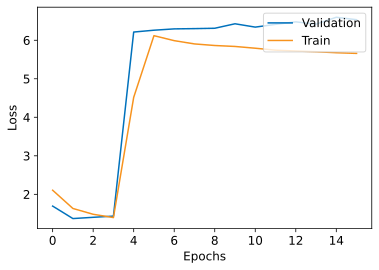

In [106]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
 .plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")
 
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

훈련 손실과 검증 손실이 상당히 줄어든 것 같으니 이 모델을 기반으로 분류기를 미세 튜닝해 성능이 올라가는지 확인해보자.

## 9.5.2 분류기 미세 튜닝하기

### 미세 튜닝 과정을 반복한다.
하지만 조금 다르게 앞서 만든 체크포인트를 로드한다.

In [107]:
model_ckpt = "bert-base-uncased-issues-128"
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA는 도메인 적응을 의미합니다
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6679, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.6114267110824585, 'eval_micro f1': 0.15555555555555559, 'eval_macro f1': 0.03575989782886335, 'eval_runtime': 0.5349, 'eval_samples_per_second': 198.152, 'eval_steps_per_second': 7.477, 'epoch': 1.0}
{'loss': 0.5619, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.5205235481262207, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5354, 'eval_samples_per_second': 197.965, 'eval_steps_per_second': 7.47, 'epoch': 2.0}
{'loss': 0.4781, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.44644680619239807, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5339, 'eval_samples_per_second': 198.535, 'eval_steps_per_second': 7.492, 'epoch': 3.0}
{'loss': 0.4246, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.412960022687912, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5335, 'eval_samples_per_second': 198.693, 'eval_steps_per_second': 7.498, 'epoch': 4.0}
{'loss': 0.39

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.6227, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.5490158796310425, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5334, 'eval_samples_per_second': 198.716, 'eval_steps_per_second': 7.499, 'epoch': 1.0}
{'loss': 0.4791, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.4311407804489136, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5332, 'eval_samples_per_second': 198.794, 'eval_steps_per_second': 7.502, 'epoch': 2.0}
{'loss': 0.4059, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.39666494727134705, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.534, 'eval_samples_per_second': 198.517, 'eval_steps_per_second': 7.491, 'epoch': 3.0}
{'loss': 0.3652, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3768059313297272, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5361, 'eval_samples_per_second': 197.738, 'eval_steps_per_second': 7.462, 'epoch': 4.0}
{'loss': 0.3555, 'learning_rate': 3e-05, 'ep

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5702, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.45134493708610535, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5791, 'eval_samples_per_second': 183.036, 'eval_steps_per_second': 6.907, 'epoch': 1.0}
{'loss': 0.4078, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.387139230966568, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5344, 'eval_samples_per_second': 198.359, 'eval_steps_per_second': 7.485, 'epoch': 2.0}
{'loss': 0.3603, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3686312437057495, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5358, 'eval_samples_per_second': 197.829, 'eval_steps_per_second': 7.465, 'epoch': 3.0}
{'loss': 0.3454, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.36356592178344727, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5371, 'eval_samples_per_second': 197.359, 'eval_steps_per_second': 7.447, 'epoch': 4.0}
{'loss': 0.3358, 'learning_rate': 3e-05, 'e

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.5016, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.3922044038772583, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5354, 'eval_samples_per_second': 198.0, 'eval_steps_per_second': 7.472, 'epoch': 1.0}
{'loss': 0.3697, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3638274371623993, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5451, 'eval_samples_per_second': 194.45, 'eval_steps_per_second': 7.338, 'epoch': 2.0}
{'loss': 0.3546, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3622680902481079, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5407, 'eval_samples_per_second': 196.052, 'eval_steps_per_second': 7.398, 'epoch': 3.0}
{'loss': 0.3498, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.3589248061180115, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5393, 'eval_samples_per_second': 196.533, 'eval_steps_per_second': 7.416, 'epoch': 4.0}
{'loss': 0.3371, 'learning_rate': 3e-05, 'epoch

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4327, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.36711108684539795, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5384, 'eval_samples_per_second': 196.868, 'eval_steps_per_second': 7.429, 'epoch': 1.0}
{'loss': 0.3547, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3609376549720764, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5378, 'eval_samples_per_second': 197.082, 'eval_steps_per_second': 7.437, 'epoch': 2.0}
{'loss': 0.3404, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.3643262982368469, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5422, 'eval_samples_per_second': 195.517, 'eval_steps_per_second': 7.378, 'epoch': 3.0}
{'loss': 0.322, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.38934415578842163, 'eval_micro f1': 0.21674876847290642, 'eval_macro f1': 0.04569055036344756, 'eval_runtime': 0.5512, 'eval_samples_per_second': 192.308, 'eval_steps_per_second': 7.257, 'epoch': 4.0}
{'loss': 0.

/home/jj/anaconda3/envs/NLP/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 0.4042, 'learning_rate': 3e-05, 'epoch': 1.0}
{'eval_loss': 0.36212170124053955, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.7682, 'eval_samples_per_second': 137.983, 'eval_steps_per_second': 5.207, 'epoch': 1.0}
{'loss': 0.3407, 'learning_rate': 3e-05, 'epoch': 2.0}
{'eval_loss': 0.3520452082157135, 'eval_micro f1': 0.0, 'eval_macro f1': 0.0, 'eval_runtime': 0.5834, 'eval_samples_per_second': 181.696, 'eval_steps_per_second': 6.856, 'epoch': 2.0}
{'loss': 0.3264, 'learning_rate': 3e-05, 'epoch': 3.0}
{'eval_loss': 0.37628352642059326, 'eval_micro f1': 0.23076923076923075, 'eval_macro f1': 0.05426356589147287, 'eval_runtime': 0.5693, 'eval_samples_per_second': 186.193, 'eval_steps_per_second': 7.026, 'epoch': 3.0}
{'loss': 0.3005, 'learning_rate': 3e-05, 'epoch': 4.0}
{'eval_loss': 0.37892717123031616, 'eval_micro f1': 0.23204419889502761, 'eval_macro f1': 0.054901960784313725, 'eval_runtime': 0.5754, 'eval_samples_per_second': 184.228, 'eval_steps_per_second

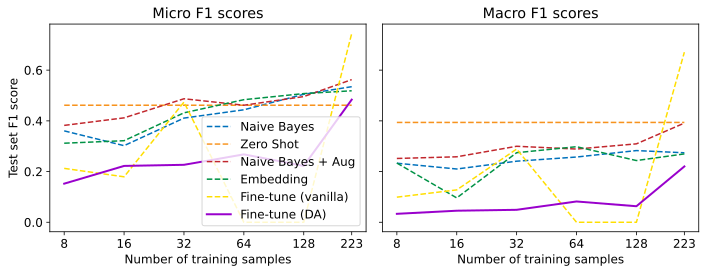

In [108]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

근데 그림이 좀 이상한듯? Fine-tuen(DA)가 가장 많은 샘플에서는 가장 높게 떠야 하는데 뭔가 제대로 학습이 안된듯 함.

기본 BERT를 기반으로 미세 튜닝한 결과와 비교하면, 특히 데이터가 부족한 도메인에서 유리하다.  
레이블링된 데이터가 더 많은 상황에서는 몇 퍼센트 포인트가 향상되기도 한다.

## 9.5.3 고급방법

비지도 데이터 증식(UDA)

불확실성 인지 자기 훈련(UST)

# 9.6 결론
### 이 장에서는 레이블이 전혀 없거나 조금만 있는 경우라도 모델을 만드는 방법이 있다는 것을 알음.  
BERT모델이나 GPT-2처럼 다른 작업에 사용하기 위해 만들어진 pretrained model을 이용해 새로운 작업에서 예측을 만드는 일이다.  
또 일반적인 분류 헤드를 가진 모델을 훈련할 때 도메인 적응(DA)를 사용해 추가적으로 성능을 향상시킬 수 있다.  

#### 여기서 소개한 방법 중 특정 문제에 가장 잘 맞는 방법이 무엇인지는 다양한 요소에 따라 달라진다.
1. 레이블링된 데이터가 얼마나 많은지  
2. 데이터에 잡음이 얼마나 많은지  
3. 데이터가 사전 훈련된 말뭉치에 얼마나 가까운지 등

#### 가장 잘 맞는 방법을 찾으려면 평가 파이프라인을 준비하고 빠르게 반복해보는 것이 좋다.

그리고 허깅페이스 허브에는 (230814기준) 29만 개가 넘는 모델이 있으니 이전에 누군가가 비슷한 문제를 다뤘을 가능성이 다분하다. 이를 기반으로 모델을 구축해도 된다.